# Mini Project 1

### Luis Pereda

In [98]:
# This is for ECE580: Intro to machine learning Spring 2020 in Duke
# This is translated to Python from show_chanWeights.m file provided by Prof. Li by 580 TAs

# import ext libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# from scipy.misc import imread   # Make Sure you install the required packages like Pillow and scipy

def imgRead(fileName):
    """
    load the input image into a matrix
    :param fileName: name of the input file
    :return: a matrix of the input image
    Examples: imgIn = imgRead('lena.bmp')
    """
    imgIn = plt.imread(fileName)
    return imgIn


def imgShow(imgOut, title):
    """
    show the image saved in a matrix
    :param imgOut: a matrix containing the image to show
    :return: None
    """
    imgOut = np.uint8(imgOut)
    plt.figure(figsize=[20,20])
    plt.imshow(imgOut, cmap = 'gray')
    plt.axis("off")
    plt.rcParams.update({"font.size":40})
    plt.title(title)


def imgRecover(imgIn, blkSize, numSample):
    """
    Recover the input image from a small size samples
    :param imgIn: input image
    :param blkSize: block size
    :param numSample: how many samples in each block
    :return: recovered image
    """
    ##### Your Implementation here

    return None

"""
if __name__ == '__main__':
    a = imgRead('lena.bmp')
    print(np.shape(a))
    imgShow(a)
    print(a)
"""

"\nif __name__ == '__main__':\n    a = imgRead('lena.bmp')\n    print(np.shape(a))\n    imgShow(a)\n    print(a)\n"

In [99]:
fishing_boat = imgRead("fishing_boat.bmp")

In [100]:
nature = imgRead("nature.bmp")

In [101]:
imgShow(nature)

TypeError: imgShow() missing 1 required positional argument: 'title'

In [102]:
nature.shape

(512, 640)

In [103]:
import random

def sample_block(block, num_samples):
#     block = blocks[1]
    indices = np.linspace(0, np.prod(block.shape) - 1, np.prod(block.shape))
    random.shuffle(indices)
    
    kept_indices = indices[(len(indices) - num_samples):]
    kept_indices = [int(x) for x in kept_indices]
    
    indices = indices[0:(len(indices) - num_samples)]
    indices = [int(x) for x in indices]
    ret = block.flatten()
    ret[indices] = 0
    ret = ret.reshape([block.shape[0], block.shape[1]])
    
    
    return ret, np.sort(np.array(kept_indices))

In [104]:
def get_blocks_from_image(image, N):
    blocks = []
    for i in range(image.shape[0] // N):
        for j in range(image.shape[1] // N):
            blocks.append(image[(i * N):((i + 1) * N), (j * N):((j + 1) * N)])
    return np.array(blocks)

In [105]:
blocks = get_blocks_from_image(nature, 16)
block = blocks[1]
block1, indices = sample_block(block, 200)

In [106]:
len(indices)

200

In [107]:
fishing_boat.shape

(200, 192)

In [108]:
x = fishing_boat.shape[1] / 8
x.is_integer()

True

In [109]:
# Get sampled image where num_samples are taken from each NXN block
def get_sampled_image(image, N, num_samples):
    blocks = get_blocks_from_image(image, N)
    
    block_count = 0
    new_blocks = np.ndarray(image.shape)
    col_reps = image.shape[1] / N
    
    if not col_reps.is_integer():
        print("Cannot split image into {} by {} blocks, select a new value N".format(N, N))
    
    else:
        col_reps = int(col_reps)
        for block in blocks:
            sample, trash = sample_block(block, num_samples)

            # For row in block
            for i in range(block.shape[0]):
                new_blocks[N * (block_count // col_reps) + i][N * (block_count % col_reps) : N * (block_count % col_reps + 1)] = sample[i]
            block_count += 1
        return new_blocks

In [212]:
new_blocks = get_sampled_image(nature, 16, 200)

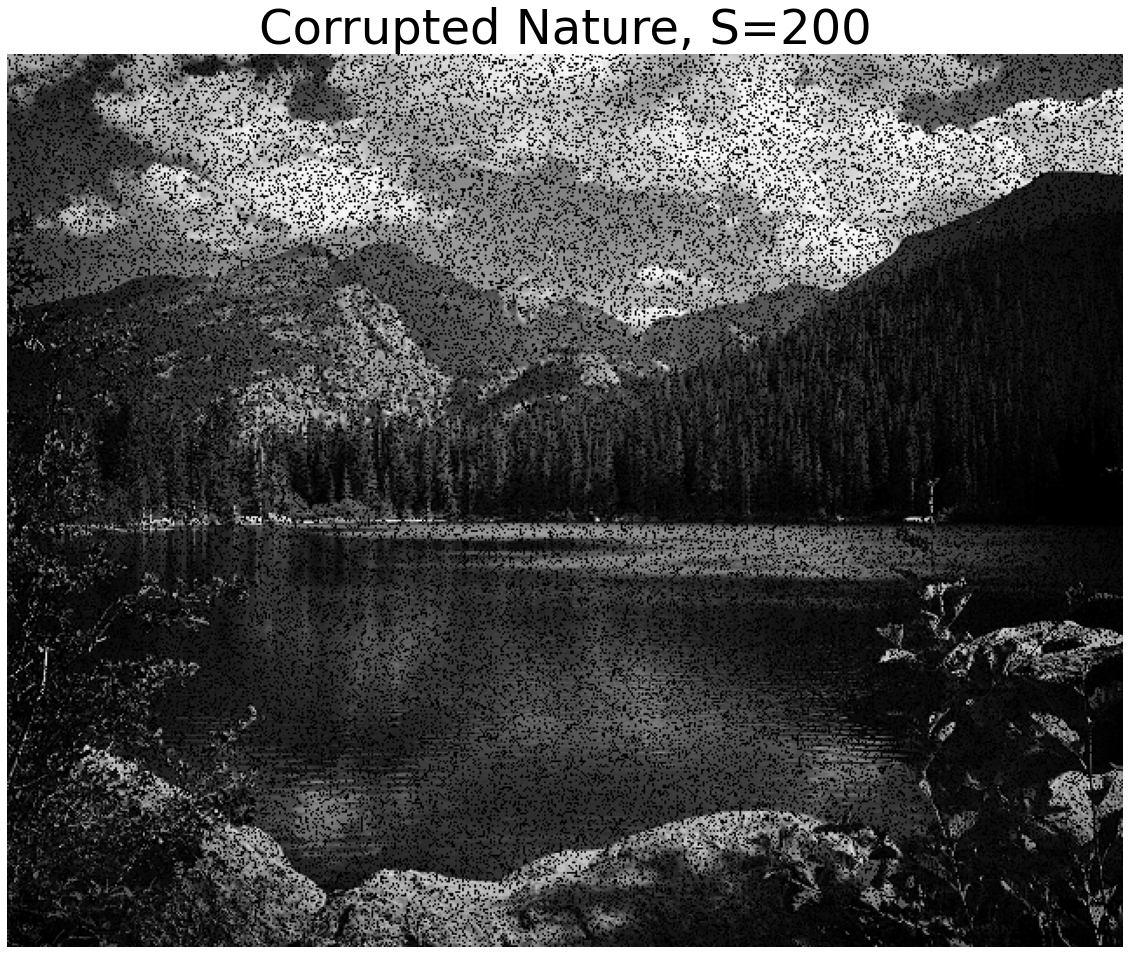

In [213]:
imgShow(new_blocks, "Corrupted Nature, S=200")

Up to this point have shown I can complete up to the first checkpoint: able to split image into NXN blocks and sample n samples from any of these blocks. 

In [112]:
from sklearn.linear_model import Lasso

In [113]:
def rasterize(mat):
    return mat.flatten()

In [114]:
def find_T_col(u, v, P, Q):
    T = np.ndarray([P,Q])
    for x in range(1, P + 1):
        for y in range(1, Q + 1):
            if u == 1:
                alpha = np.sqrt(1/P)
            else:
                alpha = np.sqrt(2/P)
            if v == 1: 
                beta = np.sqrt(1/Q)
            else:
                beta = np.sqrt(2/Q)
            term1 = np.cos(np.pi * (2 * x - 1) * (u - 1) / (2 * P))
            term2 = np.cos(np.pi * (2 * y - 1) * (v - 1) / (2 * Q))

            T[x-1][y-1] = alpha * beta * term1 * term2
    return rasterize(T)

In [115]:
def find_T_matrix(P, Q):
    T_mat = []
    for u in range(1, P + 1):
        for v in range(1, Q + 1):
            T_col = find_T_col(u, v, P, Q)
            T_mat.append(T_col)
    return np.transpose(np.array(T_mat).reshape([P ** 2, Q ** 2]))

In [116]:
T = find_T_matrix(8, 8)

In [117]:
fishing_boat_blocks = get_blocks_from_image(fishing_boat, 8)
block, inds = sample_block(fishing_boat_blocks[0], 10)

In [165]:

def find_DCT_coefs(block, N, lambda_choice, indices, T):
#     image_blocks = get_blocks_from_image(image, N)
#     block = sample_block(fishing_boat_blocks[0], num_samples)
#     block = rasterize(block)
    B = block
    A = T[indices]
    DC = A[:, 0]
    A = A[:, 1:]
    DCT_coef_predictor = Lasso(alpha = lambda_choice)
    DCT_coef_predictor.fit(X = A, y = B.flatten())
    DC_term = [DCT_coef_predictor.intercept_ / DC[0]]
#     print(DCT_coef_predictor.intercept_)
    DCT_coefs = np.array(DC_term + list(DCT_coef_predictor.coef_))
    return DCT_coefs

In [148]:
blocks = get_blocks_from_image(fishing_boat, 8)

In [151]:
block, indices = sample_block(blocks[0], 30)

In [152]:
T = find_T_matrix(8, 8)

In [158]:
DCT = find_DCT_coefs(block.flatten()[indices], 8, 0.1, indices, T)

178.9288895592981


In [164]:
T[50][0] * DCT[0]

178.9288895592981

Up to this point done with checkpoint 2: can estimate DCT for a single block 

In [119]:
import random

def find_training_and_test_set(block, S, indices):
    block = rasterize(block)
#     b = pd.DataFrame(np.array([x for x in block if x != 0]))
    b = pd.DataFrame(block[indices])
    indices = set(range(0, S))
    test_indices = set(random.sample(range(0, S), S // 6))
    train_indices = indices - test_indices
    
    train_values = b.iloc[np.sort(list(train_indices))]
    test_values = b.iloc[np.sort(list(test_indices))]
    return train_values, test_values, np.array(list(train_indices)), test_indices

In [120]:
def find_T_rows(test_indices, N, T):
    T = pd.DataFrame(T)
    T = T.iloc[np.sort(list(test_indices))]
    return T.to_numpy()

In [260]:
from sklearn.metrics import mean_squared_error as MSE
     
def find_lambda(block, num_samples, N, indices, T):
    lambda_candidates = np.logspace(-6, 6, 60)
    min_mse = 100000000
    
    for lam in lambda_candidates:
        mse_av = 0
        for i in range(1):
            train_values, test_values, train_indices, test_indices = find_training_and_test_set(block, num_samples, indices)
            train_arr = train_values.to_numpy().flatten()
            DCT_coefs = find_DCT_coefs(train_arr, N, lam, train_indices, T)
            T_rows = find_T_rows(test_indices, N, T)
            predictions = np.matmul(T_rows, DCT_coefs)
            mse = MSE(test_values, predictions)
            mse_av += mse
        mse_av /= 20
        
        if(mse_av < min_mse):
            min_mse = mse_av
            ideal_lambda = lam
    return ideal_lambda

In [122]:
# def find_empty_indices(block):
#     b = block.flatten()
#     indices = [index for index, x in zip(range(len(b)), b) if x == 0]
#     return indices

In [123]:
def find_empty_indices(block, indices): 
    b = block.flatten()
    total = set(range(len(b)))
    empties = np.array(list(total - set(indices)))
    return empties

In [124]:
# NxN block 
def reconstruct_block(block, lamb, N, indices, T):
    block = rasterize(block)
#     b = np.array([x for x in block if x != 0])
    b = block[indices]
    DCT_coefs = find_DCT_coefs(b, N, lamb, indices, T)
    empties = find_empty_indices(block, indices)
    
    T_rows = find_T_rows(empties, N, T)
    reconstructed_pixels = np.matmul(T_rows, DCT_coefs)
    
    reconstructed_block = pd.DataFrame(block)
    reconstructed_block.iloc[empties] = reconstructed_pixels
    reconstructed_block = reconstructed_block.to_numpy().reshape([N, N])
    
    return reconstructed_block

At this point able to reconstruct a block using cross-validation to find a lambda for LASSO regression

In [125]:
def save_image(image_name, image):
    np.savetxt(image_name, image, delimiter=',')

In [126]:
import timeit

def reconstruct_image(image, N, num_samples, file_name):
    start = timeit.default_timer()
    
    T = find_T_matrix(N, N)
    image_blocks = get_blocks_from_image(image, N)
    reconstructed_blocks = []
    
    for image_block in image_blocks:
        block, indices = sample_block(image_block, num_samples)
        lamb = find_lambda(block, num_samples, N, indices, T)
        reconstructed = reconstruct_block(block, lamb, N, indices, T)
        reconstructed_blocks.append(reconstructed)
    print(np.prod([image.shape[0] // N, image.shape[1] // N]))
    reconstructed_blocks = np.array(reconstructed_blocks).reshape([np.prod([image.shape[0] // N, image.shape[1] // N]) , N, N])
    
    block_count = 0
    new_blocks = np.ndarray(image.shape)
    col_reps = image.shape[1] / N

    col_reps = int(col_reps)
    for block in reconstructed_blocks:

        # For row in block
        for i in range(block.shape[0]):
            new_blocks[N * (block_count // col_reps) + i][N * (block_count % col_reps) : N * (block_count % col_reps + 1)] = block[i]
        block_count += 1
        
    save_image(file_name, new_blocks)
    
    stop = timeit.default_timer()
    
    print("Time:", (stop - start) / 60 )
    return new_blocks

In [127]:
nature_reconstructed_200 = reconstruct_image(nature, 16, 200, "nature_200.csv")

KeyboardInterrupt: 

In [261]:
nature_reconstructed_150 = reconstruct_image(nature, 16, 150, "nature_150_no_cv.csv")

1280
Time: 9.208943637349996


In [ ]:
nature_reconstructed_100 = reconstruct_image(nature, 16, 100, "nature_100_no_cv.csv")

In [40]:
nature_reconstructed_50 = reconstruct_image(nature, 16, 50, "nature_50_no_cv.csv")

1280


In [35]:
nature_reconstructed_30 = reconstruct_image(nature, 16, 30, "nature_30_no_cv.csv")

1280
Time: 143.14201829231666


In [36]:
nature_reconstructed_10 = reconstruct_image(nature, 16, 10, "nature_10_no_cv.csv")

1280
Time: 94.11946172681668


In [265]:
fishing_boat_reconstructed_10 = reconstruct_image(fishing_boat, 8, 10, "fishing_boat_10_no_cv.csv")

600
Time: 1.3258970382666424


In [266]:
fishing_boat_reconstructed_20 = reconstruct_image(fishing_boat, 8, 20, "fishing_boat_20_no_cv.csv")

600
Time: 1.307360200100023


In [267]:
fishing_boat_reconstructed_30 = reconstruct_image(fishing_boat, 8, 30, "fishing_boat_30_no_cv.csv")

600
Time: 1.409264809366626


In [ ]:
fishing_boat_reconstructed_40 = reconstruct_image(fishing_boat, 8, 40, "fishing_boat_40_no_cv.csv")

In [ ]:
fishing_boat_reconstructed_50 = reconstruct_image(fishing_boat, 8, 50, "fishing_boat_50_no_cv.csv")

In [140]:
fishing_boat_reconstructed_63 = reconstruct_image(fishing_boat, 8, 63, "fishing_boat_63.csv")

600


In [262]:
boat = pd.read_csv("nature_150_no_cv.csv", header=None)
boat = boat.to_numpy()

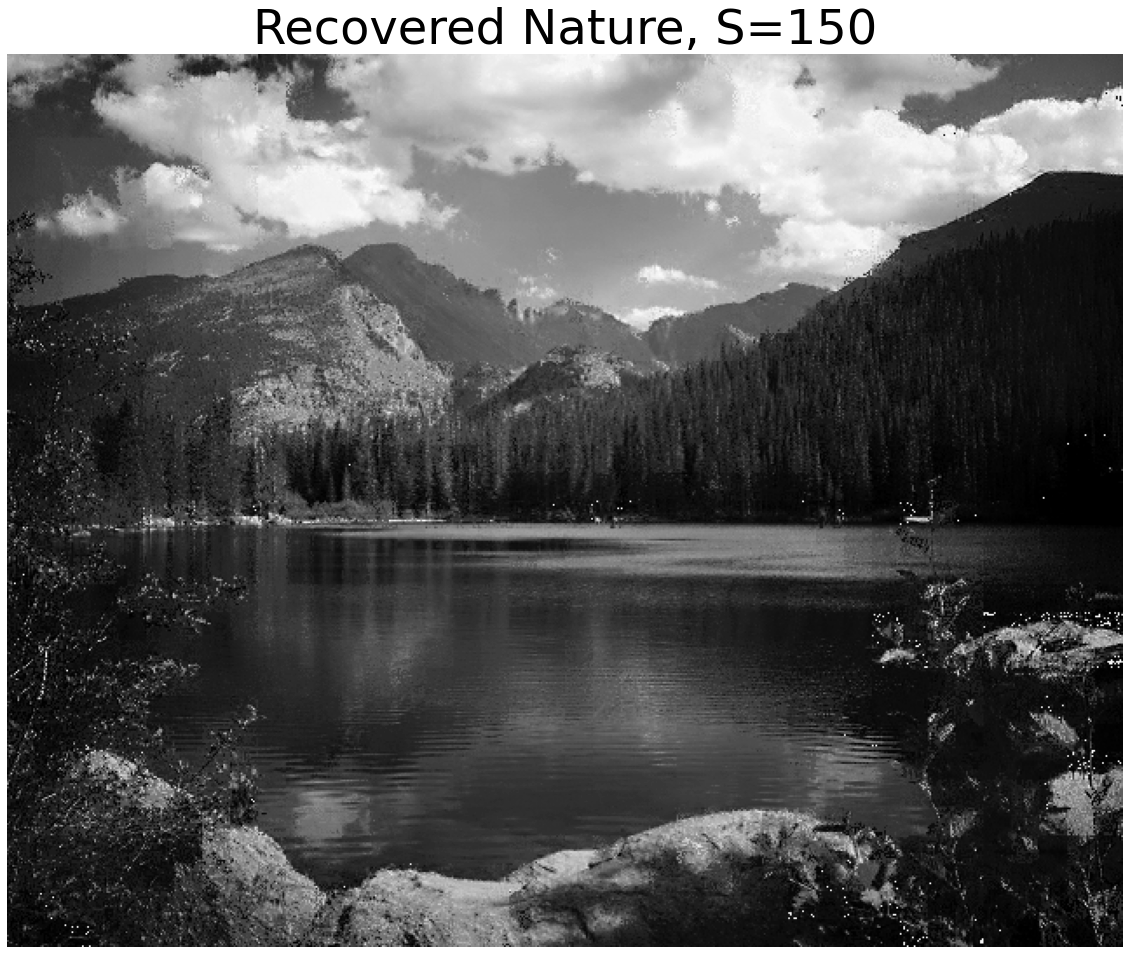

In [263]:
imgShow(boat, "Recovered Nature, S=150")

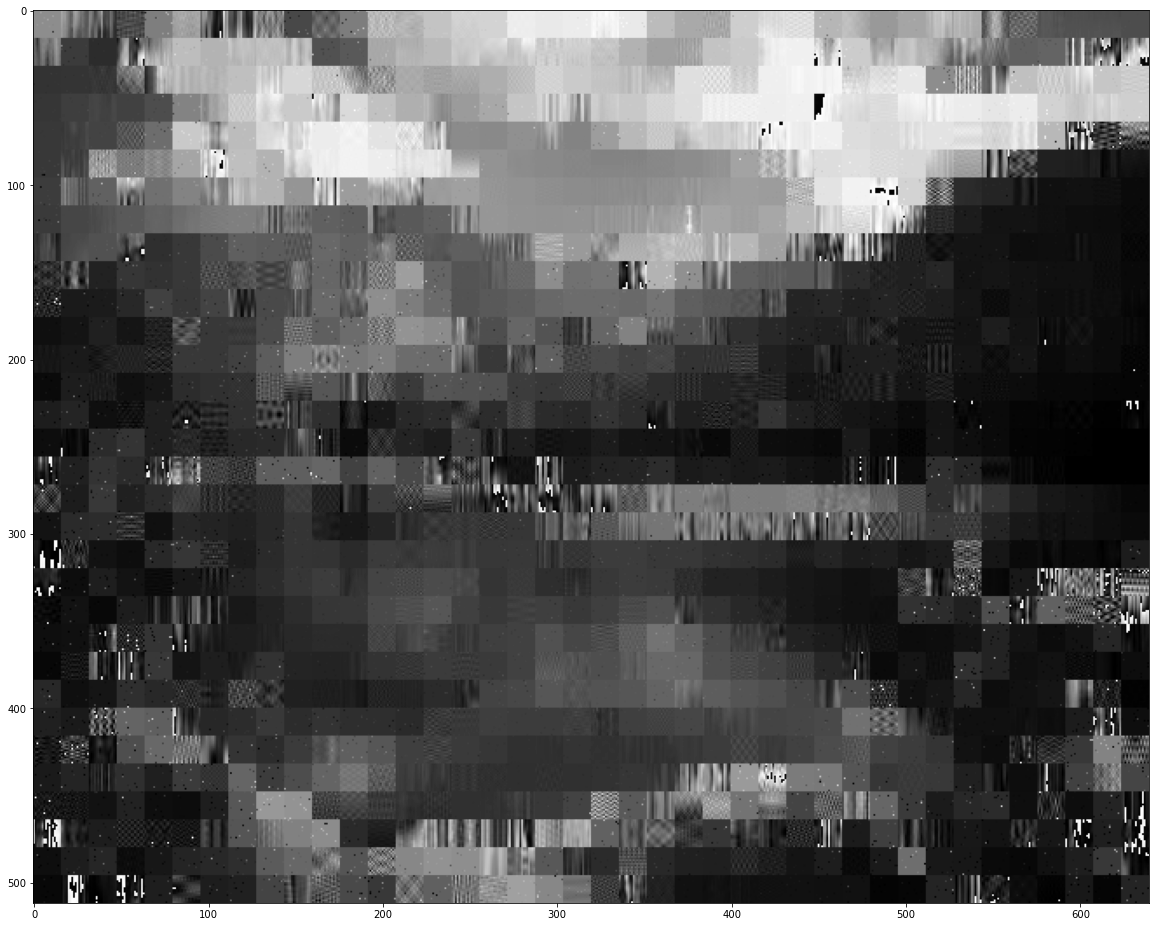

In [83]:
imgShow(boat)

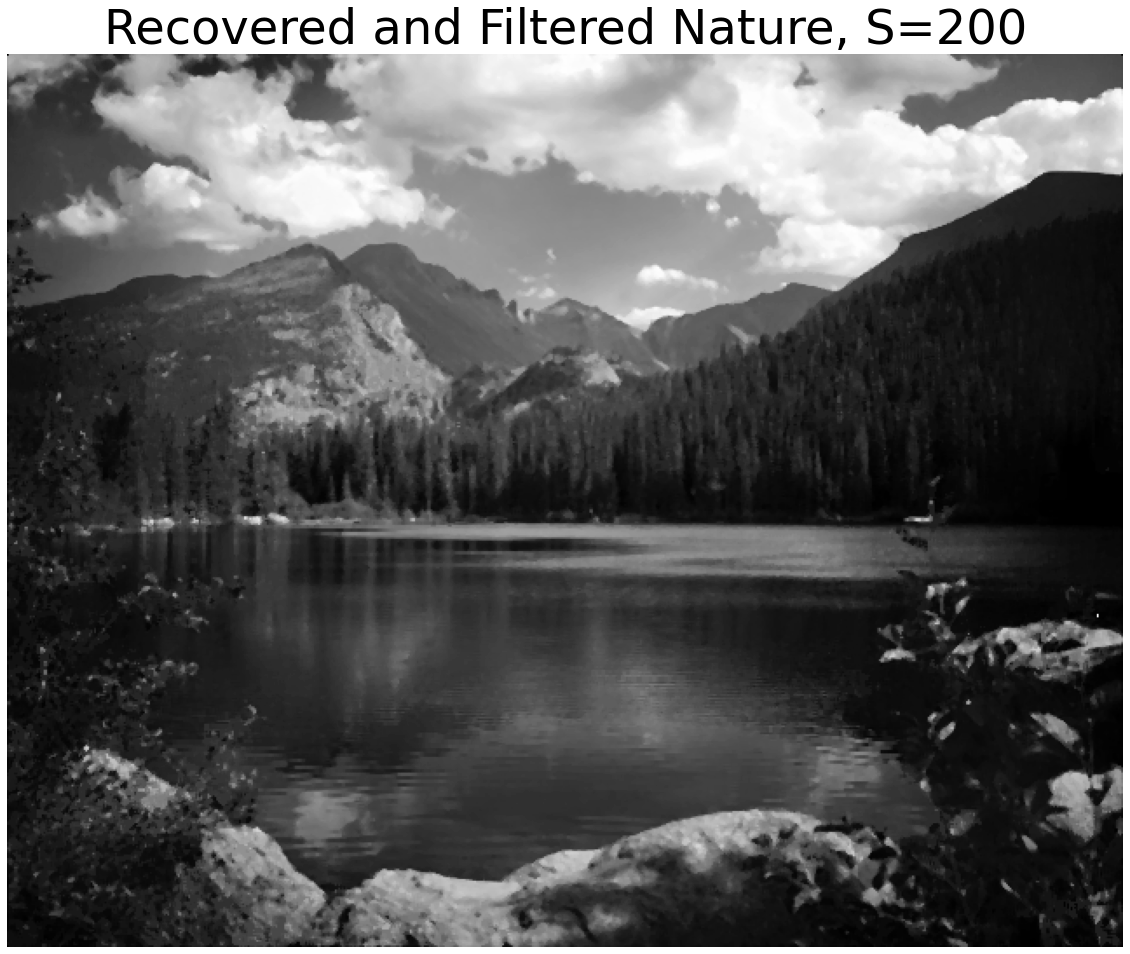

In [258]:
from scipy.ndimage import median_filter
from scipy.signal import medfilt2d
from scipy.ndimage import gaussian_filter

boat2 = medfilt2d(boat, [3,3])
imgShow(medfilt2d(boat, [3,3]), "Recovered and Filtered Nature, S=200")

In [264]:
MSE(nature, boat)

180.7730271538162